# Construccion modelo Precio Vivienda

** Relevant Information: Concerns housing values in suburbs of Boston.
** Number of Instances: 509
** Number of Attributes: 13 continuous attributes (including "class" attribute "MEDV"), 1 binary-valued attribute.

Attribute Information:

1) CRIM : per capita crime rate by town.

2) ZN : proportion of residential land zoned for lots over 25,000 sq.ft.

3) INDUS: proportion of non-retail business acres per town.

4) CHAS : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

5) NOX : nitric oxides concentration (parts per 10 million).

6) RM : average number of rooms per dwelling.

7) AGE : proportion of owner-occupied units built prior to 1940.

8) DIS : weighted distances to five Boston employment centres.

9) RAD : index of accessibility to radial highways.

10) TAX : full-value property-tax rate per 10,000.

11) PTRATIO : pupil-teacher ratio by town.

12) B : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

13) LSTAT: % lower status of the population.

14) MEDV : Median value of owner-occupied homes in 1000's.*

### Importamos Librerías

In [1]:
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Tratamiento de datos
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Feature selection
from sklearn.model_selection import train_test_split, StratifiedKFold

# Modelos ML
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import xgboost as xgb



# Evaluación del modelo
import shap
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, r2_score

# Guardar modelo
import pickle

### Parámetros del Notebook

In [2]:
n_jobs = 2

### Carga de Datos

In [3]:
df_in = pd.read_csv('./Housing.csv',
                    sep = ",",
                    encoding = "latin-1",
                    low_memory=False)
df_in.shape

(509, 14)

In [4]:
df_in.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222,18.7,396.90,5.33,36.2


In [5]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     509 non-null    float64
 1   ZN       509 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     509 non-null    int64  
 4   NOX      507 non-null    float64
 5   RM       509 non-null    float64
 6   AGE      508 non-null    float64
 7   DIS      509 non-null    float64
 8   RAD      508 non-null    float64
 9   TAX      509 non-null    int64  
 10  PTRATIO  509 non-null    float64
 11  B        509 non-null    float64
 12  LSTAT    508 non-null    float64
 13  MEDV     509 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.8 KB


### Análisis Descriptivo

In [6]:
plt.rcParams['figure.figsize'] = (15,6)

#### Distribución del Precio de la Vivienda

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


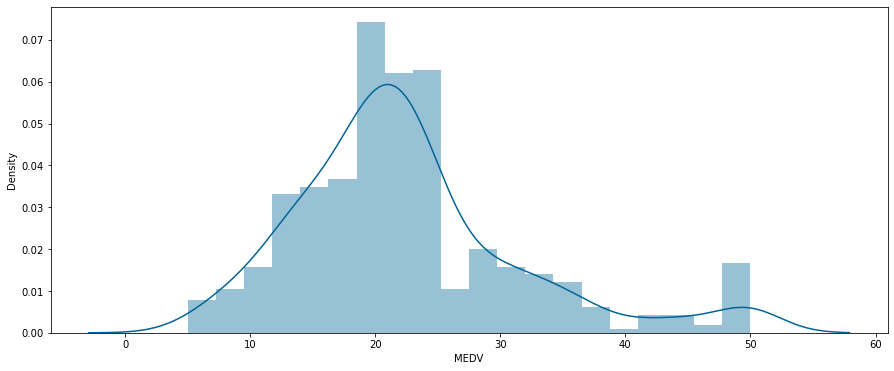

In [7]:
sns.distplot(a=df_in.MEDV, color='#006496', bins=20);

#### Distribución por Precio de la Vivienda y la Tasa de Criminalidad

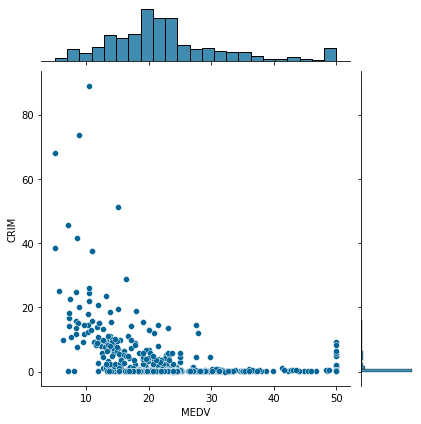

In [8]:
sns.jointplot(data=df_in, x='MEDV', y='CRIM', color='#006496')

#### Distribución por Precio de la Vivienda y Nº de Habitaciones

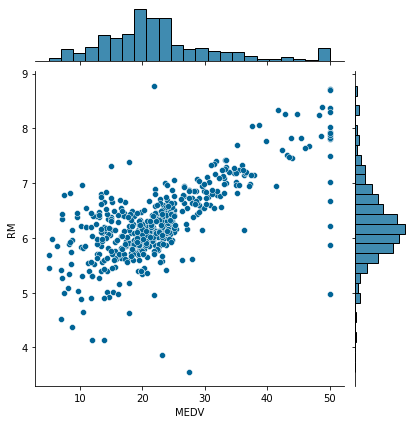

In [9]:
sns.jointplot(data=df_in, x='MEDV', y='RM', color='#006496')

### Preproceso de Datos

Primero y, dado que hay pocos valores missings, borramos del dataset aquellas filas que los contengan

In [10]:
for index, num in zip(df_in.isna().sum().index, df_in.isna().sum().values):
    if num > 0:
        print(index, num)

INDUS 3
NOX 2
AGE 1
RAD 1
LSTAT 1


In [11]:
df_in.dropna(axis=0, inplace=True)
print(df_in.shape)

(501, 14)


#### Dataset train y test

In [12]:
y = df_in.MEDV 
X = df_in.drop('MEDV', axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

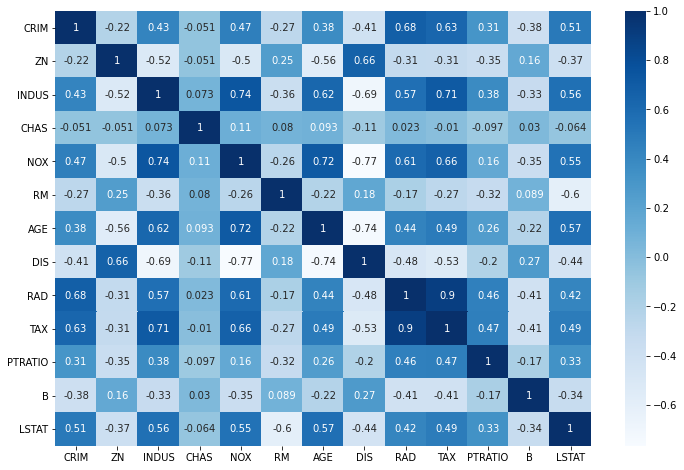

In [14]:
corr = X_train.corr()
plt.rcParams['figure.figsize'] = (12, 8) 
sns.heatmap(corr, cmap="Blues", annot=True);

In [15]:
# Calcular la matriz de correlación
correlation_matrix = X_train.corr().abs()

# Crear una matriz booleana para marcar las características a eliminar
mask = np.triu(np.ones(correlation_matrix.shape, dtype=bool))

# Encontrar pares de características altamente correlacionadas
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.7:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            if colname_i not in highly_correlated_features:
                highly_correlated_features.add(colname_j)

# Filtrar X_train y X_test excluyendo las características altamente correlacionadas
X_train_filtered = X_train.drop(columns=highly_correlated_features)
X_test_filtered = X_test.drop(columns=highly_correlated_features)

In [16]:
# Obtener las columnas originales de X_train
original_columns = X_train.columns

# Filtrar X_train y X_test excluyendo las características altamente correlacionadas
X_train_filtered = X_train.drop(columns=highly_correlated_features)
X_test_filtered = X_test.drop(columns=highly_correlated_features)

# Obtener las columnas filtradas de X_train
filtered_columns = X_train_filtered.columns

# Obtener las columnas eliminadas
eliminated_columns = list(set(original_columns) - set(filtered_columns))

# Imprimir las columnas eliminadas
print("Variables eliminadas:", eliminated_columns)

Variables eliminadas: ['DIS', 'TAX', 'NOX']


### Tuneado de hiperparámetros

In [17]:
# Convertimos los conjuntos de datos a una estructura de datos DMatrix específica de XGBoost
dtrain = xgb.DMatrix(X_train_filtered, label=y_train)

# Definimos los parámetros a buscar
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'objective': ['reg:squarederror'],  
}

# Modelo base XGBoost
base_model = xgb.XGBRegressor()

# GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_filtered, y_train)

# Obtenemos el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Vemos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'}


### Ejecutamos con hiperparámetros óptimos

In [18]:
# Predicciones en el conjunto de prueba utilizando el mejor modelo
predictions = best_model.predict(X_test_filtered)

# Calculamos las métricas de evaluación con el mejor modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Vemos las métricas de evaluación
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 10.555810426872064
Mean Absolute Error (MAE): 2.2849463368093734
R-squared (R2): 0.8655292021585688


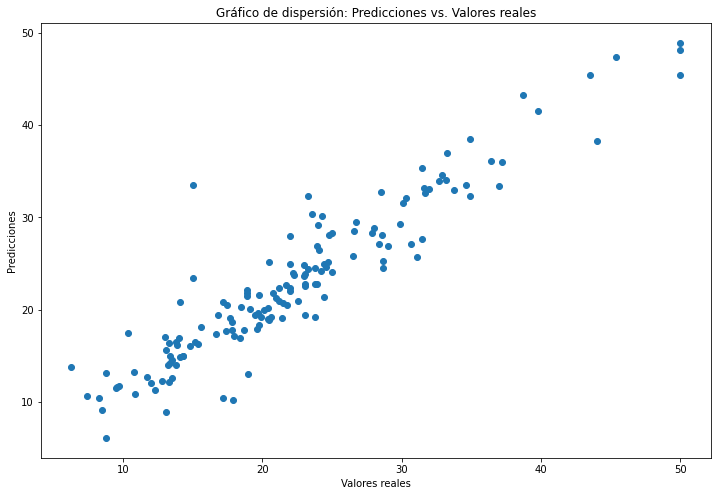

In [19]:
# Gráfico de dispersión
plt.scatter(y_test, predictions)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Predicciones vs. Valores reales')
plt.show() 

#### Guardamos el modelo

In [20]:
pickle.dump(best_model, open('modelo_precio_vivienda.cls', 'wb'))

#### Cargamos modelo

In [21]:
modelo_input = pickle.load(open('./modelo_precio_vivienda.cls', "rb"))

#### Explicabilidad de las variables

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


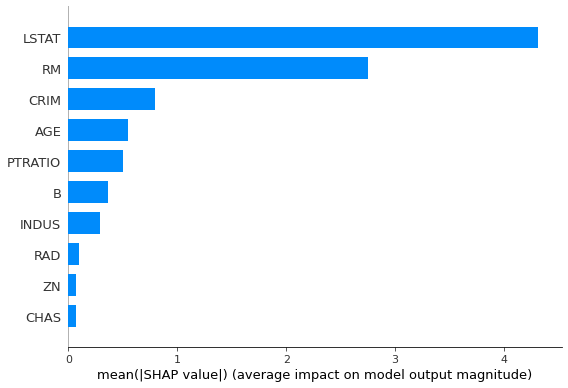

In [22]:
# Crear un objeto explainer utilizando el mejor modelo entrenado
explainer = shap.Explainer(best_model)

# Calcular los valores SHAP para las variables de interés
shap_values = explainer.shap_values(X_train_filtered)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_train_filtered, plot_type='bar')

In [23]:
# Crear un DataFrame con los valores SHAP
shap_df = pd.DataFrame(shap_values, columns=X_train_filtered.columns)

# Calcular la media global de los valores SHAP y su proporción relativa
mean_global = shap_df.abs().mean(axis=0).sort_values(ascending=False)
mean_global = pd.DataFrame(mean_global)
mean_global.reset_index(inplace=True)
mean_global.columns = ['variable', 'media']
mean_global['media_pct'] = mean_global['media'] / mean_global['media'].sum() 
mean_global 

,variable,media,media_pct
0,LSTAT,4.313240,0.441168
1,RM,2.752067,0.281488
2,CRIM,0.791825,0.080990
3,AGE,0.542688,0.055507
4,PTRATIO,0.498557,0.050994
5,B,0.365281,0.037362
6,INDUS,0.286785,0.029333
7,RAD,0.093369,0.009550
8,ZN,0.066600,0.006812
9,CHAS,0.066443,0.006796


In [24]:
def pintar_distribucion_shap_value(df, variable, df_shap_values, pk):
    # Primero, insertamos los índices como "private-key" para haver un merge entre valores shap y valores de x
    df = df.reset_index()
    df_shap_values['index'] = df['index']
    
    # Nos quedamos con el percentil 99 para evitar outliers en el plot
    if df[variable].dtype == "O":
        aux = df.loc[~df[variable].isna()][pk]
    else:
        if np.percentile(np.abs(df.loc[~df[variable].isna()][variable]), 97.5) <= np.abs(df[variable]).max():
            aux = df.loc[np.abs(df[variable]) <= np.percentile(np.abs(df.loc[~df[variable].isna()][variable]), 97.5)][pk]
        else:
            aux = df[pk]
    x = df.merge(aux, on=pk, how="inner")[variable]
    y = df_shap_values.merge(aux, on=pk, how="inner")[variable]*100
    color = np.where(y<0,'#0096C8', 'r') # Código colores: SHAP > 0 (<0): Rojo (Azul)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.scatter(x, y, c = color, s=5, linewidth=0)
    ax.set(title = "SHAP value scatter plot for " + variable, xlabel = variable,
           ylabel = "Variación Probabilidad" + '\n'+ r"(SHAP $\times 100$(%))");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(y=0, color='k', linestyle='-', lw = 0.4)
    if df[variable].dtype == "O":
        plt.xticks(rotation = 90)
    plt.show()

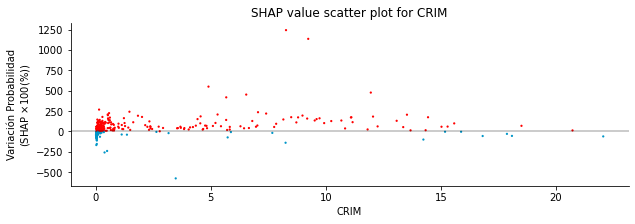

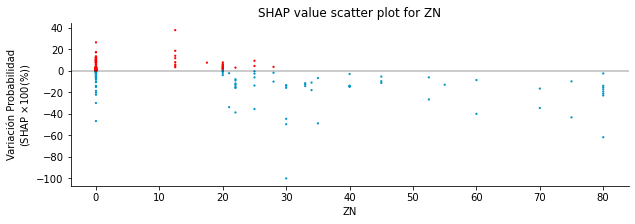

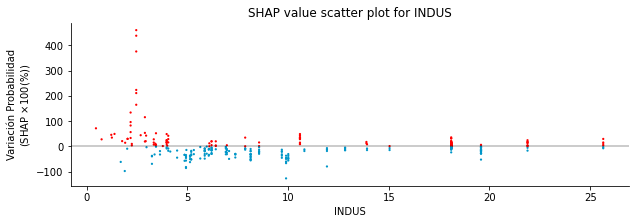

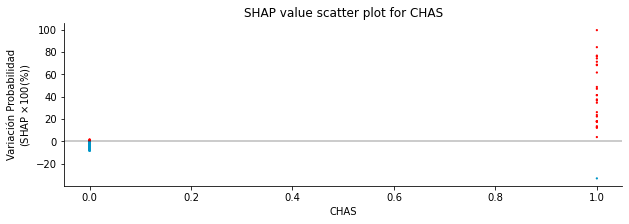

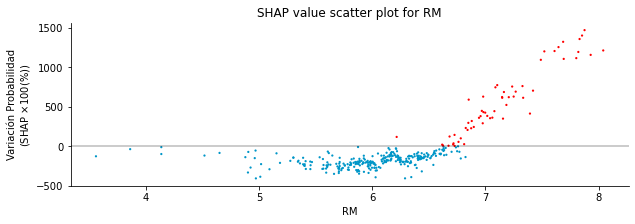

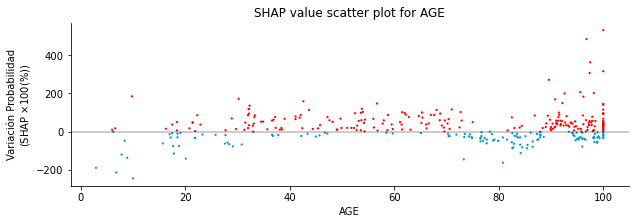

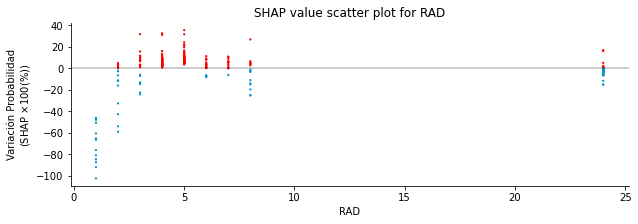

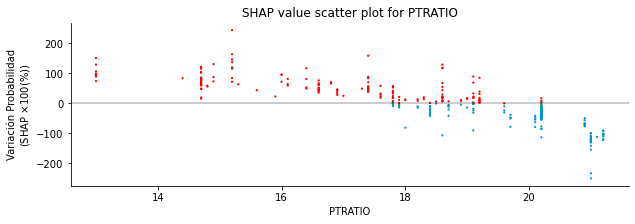

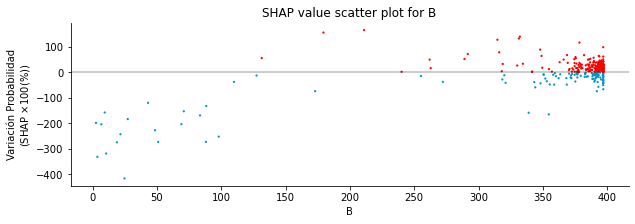

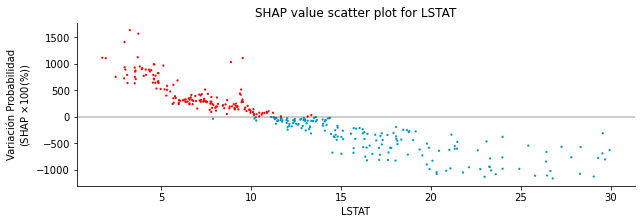

In [25]:
for variable in X_train_filtered.columns.values:
    pintar_distribucion_shap_value(X_train_filtered, variable, shap_df, ["index"])

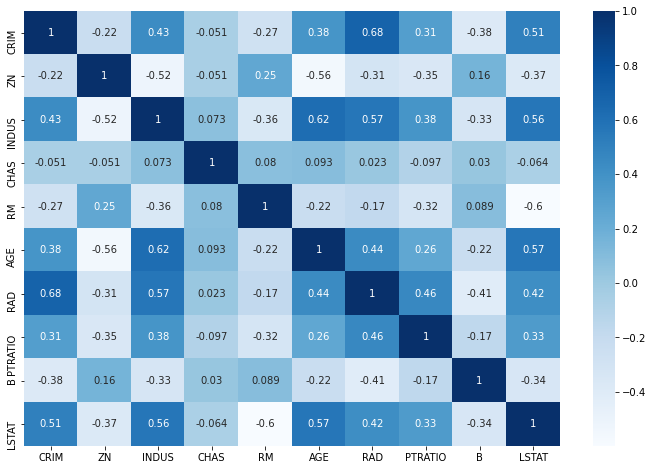

In [26]:
corr = X_train_filtered.corr()
plt.rcParams['figure.figsize'] = (12, 8) 
sns.heatmap(corr, cmap="Blues", annot=True);